# Projet Spark - Covid VS Societé 2020

## Problematique
### Quelle est l'impacte du covid sur les société en France sur l'année 2020 ?


In [56]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import *
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import unix_timestamp, from_unixtime

**Création de la session spark**

In [57]:
spark = SparkSession.builder.appName("covid_societe").getOrCreate()

**Lecture du fichier des données covid-19**

In [58]:
path_file_data = "../data/donnees_covid_societes/"

df_covid_par_dep = spark.read.csv(
    path_file_data + "covid/covid_quotidien_par_dep_du_patient/donnees-hospitalieres-nouveaux-covid19-2020-12-13-19h03.csv",
    header=True,
    sep=";"
)
df_metadonne_covid_par_dep_et_sexe_patient = spark.read.csv(
    path_file_data + "covid/covid_quotidien_par_dep_du_patient/metadonnees-hospit-incid.csv",
    header=True,
    sep=";"
)

# Affichage des metadonnés
df_metadonne_covid_par_dep_et_sexe_patient.select(
    "Colonne",
    "Type ",
    "Description_FR"
).filter(
    df_metadonne_covid_par_dep_et_sexe_patient.Colonne.isNotNull()
).show(20, False)

# Affichage des données
df_covid_par_dep = df_covid_par_dep.filter(df_covid_par_dep.jour >= '01/01/2021')
df_covid_par_dep.show()

# La plus grande date
print("La plus grande date :")
df_covid_par_dep.orderBy('jour', ascending=False).show(1)

+----------+-------------+--------------------------------------------------------+
|Colonne   |Type         |Description_FR                                          |
+----------+-------------+--------------------------------------------------------+
|dep       |integer      |Département                                             |
|jour      |string($date)|Date de notification                                    |
|incid_hosp|string       |Nombre quotidien de personnes nouvellement hospitalisées|
|incid_rea |integer      |Nombre quotidien de nouvelles admissions en réanimation |
|incid_dc  |integer      |Nombre quotidien de personnes nouvellement décédées     |
|incid_rad |integer      |Nombre quotidien de nouveaux retours à domicile         |
+----------+-------------+--------------------------------------------------------+

+---+----------+----------+---------+--------+---------+
|dep|      jour|incid_hosp|incid_rea|incid_dc|incid_rad|
+---+----------+----------+---------+--------

### Quelle departement a eu le plus d'hospitalisation, de réanimation et de déces ? (ecrire dans un csv dans /resultat)

In [59]:
df_covid_sum_par_dep = df_covid_par_dep.groupBy(
    "dep"
).agg( 
    # On fait la somme de chaque colonne puis on cast le resultat en INTEGER et on le renomme
    f.sum("incid_hosp").cast(IntegerType()).alias('incid_hosp'), 
    f.sum("incid_rea").cast(IntegerType()).alias('incid_rea'),
    f.sum("incid_rad").cast(IntegerType()).alias('incid_rad'),
    f.sum("incid_dc").cast(IntegerType()).alias('incid_dc')
).orderBy("dep",ascending=True)

# df_covid_sum_par_dep.show()

# On recupere les valeurs max
max_hospi = df_covid_sum_par_dep.groupBy().max("incid_hosp").collect()[0]["max(incid_hosp)"]
max_rea = df_covid_sum_par_dep.groupBy().max("incid_rea").collect()[0]["max(incid_rea)"]
max_dc = df_covid_sum_par_dep.groupBy().max("incid_dc").collect()[0]["max(incid_dc)"]

#### Département avec le plus d'hospitalisation

In [60]:
# Le département avec le plus d'hospitalisation
df_covid_max_hospi = df_covid_sum_par_dep.filter(
    f.col("incid_hosp") == max_hospi    
).select(
    "dep",
    "incid_hosp"
)
df_covid_max_hospi.show()

+---+----------+
|dep|incid_hosp|
+---+----------+
| 75|     15085|
+---+----------+



#### Département avec le plus de réanimation

In [61]:
# Le département avec le plus de réanimation
df_covid_max_rea = df_covid_sum_par_dep.filter(
    f.col("incid_rea") == max_rea    
).select(
    "dep",
    "incid_rea"
)
df_covid_max_rea.show()

+---+---------+
|dep|incid_rea|
+---+---------+
| 75|     3475|
+---+---------+



#### Département avec le plus de decés

In [62]:
# Le département avec le plus de decés
df_covid_max_dc = df_covid_sum_par_dep.filter(
    f.col("incid_dc") == max_dc    
).select(
    "dep",
    "incid_dc"
)
df_covid_max_dc.show()

+---+--------+
|dep|incid_dc|
+---+--------+
| 75|    2600|
+---+--------+



#### Sauvergarder dans un fichier csv 

In [63]:
path_file_save = "../resultat/"

# On est obliger de passer par pandas, sinon erreur
df_covid_max_hospi.toPandas().to_csv(path_file_save + 'departement_avec_le_plus_hospitalisation.csv')
df_covid_max_rea.toPandas().to_csv(path_file_save + 'departement_avec_le_plus_de_reanimation.csv')
df_covid_max_dc.toPandas().to_csv(path_file_save + 'departement_avec_le_plus_de_deces.csv')

# df_covid_max_hospi.write.csv(path_file_save +'departement_avec_le_plus_hospitalisation.csv')

### Réponse 
**Paris** est la ville avec le plus d'incident:
- Hospitalisation: **16 559**
- Réanimation: **3 822**
- Dèces: **2 850**

### Quelle jour a été le plus critique en hospitalisation, reanimation et deces (par departement) (ecrire dans un csv dans /resultat)
DF1: dep | jour | max(hospi)

DF2: dep | jour | max(rea)

DF3: dep | jour | max(deces)

### Lecture du fichier des societé radiees

In [64]:
path_file_data = "../data/donnees_covid_societes/"

df_societe_radie = spark.read.csv(
    path_file_data + "societe/societes-radiees-2020.csv",
    header=True,
    sep=";"
)
# df_societe_radie.show()

# On recupere uniquement les colonnes qui nous interesse
df_societe_radie = df_societe_radie.select(
    "Dénomination",
    "Num dept",
    "Département",
    "Date radiation"
)

# On Supprimme les lignes avec des valeur vide
df_societe_radie = df_societe_radie.filter(
    f.col("Num dept").isNotNull() &
    f.col("Date radiation").isNotNull()
).orderBy('Date radiation', ascending=True)

# Affichage des données
df_societe_radie.show()

# La plus grande date
print("La plus grande date :")
df_societe_radie.select("Date radiation").orderBy('Date radiation', ascending=False).show(1)

+--------------------+--------+----------------+--------------+
|        Dénomination|Num dept|     Département|Date radiation|
+--------------------+--------+----------------+--------------+
|             ARMICOM|      44|Loire-Atlantique|    01/02/2020|
|        JLD TRAITEUR|      42|           Loire|    01/02/2020|
|     L'ART A 4 MAINS|      21|       Côte d'Or|    01/02/2020|
|     LA CHOUETTE VTC|      21|       Côte d'Or|    01/02/2020|
|          SPORT KIFF|      21|       Côte d'Or|    01/02/2020|
|   HIGH TECH FINANCE|      42|           Loire|    01/02/2020|
|SOCIETE SHIRLEY P...|      92|  Hauts-de-Seine|    01/02/2020|
|           COPOPLAST|      21|       Côte d'Or|    01/02/2020|
|              AND CO|      92|  Hauts-de-Seine|    01/02/2020|
|JEROME RAVET CONSEIL|      92|  Hauts-de-Seine|    01/02/2020|
|              COMP-I|      61|            Orne|    01/02/2020|
|            SEBAFLEX|      21|       Côte d'Or|    01/02/2020|
|CHATEAU LANDON EN...|      77|  Seine-e

### Quel département a eu le plus de radiations d'entreprises en 2020 ? 


DF df_dpt_max_radie: Num dept | nombre_dentreprise_radie

In [126]:
# Nombre de societe radié par departement et par jour
df_nb_societe_radie = df_societe_radie.groupBy(
    "Num dept",
    "Date radiation",
    from_unixtime(unix_timestamp("Date radiation", 'dd/MM/yyy')).alias('Date radiation unix')
).agg(
    # On fait le count de chaque colonne puis on cast le resultat en INTEGER et on le renomme
    f.count("Num dept").cast(IntegerType()).alias('nb_societe_radie')
).orderBy("Num dept", f.col("nb_societe_radie").desc())

df_nb_societe_radie.show()

+--------+--------------+-------------------+----------------+
|Num dept|Date radiation|Date radiation unix|nb_societe_radie|
+--------+--------------+-------------------+----------------+
|       1|    16/12/2020|2020-12-16 00:00:00|             208|
|       1|    24/12/2020|2020-12-24 00:00:00|              98|
|       1|    28/09/2020|2020-09-28 00:00:00|              85|
|       1|    23/09/2020|2020-09-23 00:00:00|              67|
|       1|    18/09/2020|2020-09-18 00:00:00|              61|
|       1|    09/10/2020|2020-10-09 00:00:00|              48|
|       1|    18/06/2020|2020-06-18 00:00:00|              43|
|       1|    10/12/2020|2020-12-10 00:00:00|              35|
|       1|    05/05/2020|2020-05-05 00:00:00|              32|
|       1|    16/01/2020|2020-01-16 00:00:00|              32|
|       1|    12/03/2020|2020-03-12 00:00:00|              31|
|       1|    15/12/2020|2020-12-15 00:00:00|              30|
|       1|    12/06/2020|2020-06-12 00:00:00|          

In [127]:
df_dpt_radie = df_nb_societe_radie.groupBy(
    "Num dept"
).agg(
    # On fait la somme du nombre d'entreprises radiées par département
    f.sum("nb_societe_radie").cast(IntegerType()).alias("nombre_dentreprise_radie")
)

# On récupère la valeur maximale d'entreprises radiées
max_radie_par_dpt = df_dpt_radie.groupBy().max("nombre_dentreprise_radie").collect()[0]["max(nombre_dentreprise_radie)"]

df_dpt_radie_max = df_dpt_radie.filter(
    # On filtre par la valeur maximale d'entreprises radiées
    f.col("nombre_dentreprise_radie") == max_radie_par_dpt
).select(
    "Num dept",
    "nombre_dentreprise_radie"
)

print("Département avec le plus de radiation d'entreprise:")
df_dpt_radie_max.show()

Département avec le plus de radiation d'entreprise:
+--------+------------------------+
|Num dept|nombre_dentreprise_radie|
+--------+------------------------+
|      75|                   16716|
+--------+------------------------+



In [65]:
### Quelle est l'impacte du covid sur les société en France sur l'année 2020 ?

DF societe : Num dept | date radiation | nb_de_societe_radié

DF covid : dep   | jour           | hosp | rea | rad | dc

Df covid_societe : dep | date | nb_de_societe_radié | hosp | rea | rad | dc

+--------+--------------+-------------------+----------------+
|Num dept|Date radiation|Date radiation unix|nb_societe_radie|
+--------+--------------+-------------------+----------------+
|       1|    02/01/2020|2020-01-02 00:00:00|               7|
|       1|    03/01/2020|2020-01-03 00:00:00|               3|
|       1|    07/01/2020|2020-01-07 00:00:00|               2|
|       1|    08/01/2020|2020-01-08 00:00:00|               5|
|       1|    09/01/2020|2020-01-09 00:00:00|               1|
|       1|    10/01/2020|2020-01-10 00:00:00|               6|
|       1|    13/01/2020|2020-01-13 00:00:00|               4|
|       1|    14/01/2020|2020-01-14 00:00:00|               2|
|       1|    15/01/2020|2020-01-15 00:00:00|               3|
|       1|    16/01/2020|2020-01-16 00:00:00|              32|
|       1|    17/01/2020|2020-01-17 00:00:00|               3|
|       1|    20/01/2020|2020-01-20 00:00:00|               3|
|       1|    21/01/2020|2020-01-21 00:00:00|          

In [66]:
# Jointure entre le df des societés et du covid
df_societe_radie_join_covid = df_covid_unix.join(
    df_nb_societe_radie,
    (df_covid_unix.dep == f.col("Num dept")) & (f.col("jour unix") == f.col("Date radiation unix"))
)

# On recupere les colonnes qui nous intéresse
df_societe_radie_join_covid = df_societe_radie_join_covid.select(
    "dep",
    "jour unix",
    "incid_hosp",
    "incid_rea",
    "incid_dc",
    "incid_rad",
    "nb_societe_radie"
).orderBy("dep", "jour unix")

df_societe_radie_join_covid.show()

+---+---------+----------+---------+--------+---------+----------------+
|dep|jour unix|incid_hosp|incid_rea|incid_dc|incid_rad|nb_societe_radie|
+---+---------+----------+---------+--------+---------+----------------+
+---+---------+----------+---------+--------+---------+----------------+



In [67]:
# Nombre de incident covid et de societé radié (par departement et par mois)
df_groupby_par_dep_mois_societe_covid = df_societe_radie_join_covid.groupBy(
    f.col("dep").cast(IntegerType()).alias('dep'),
    f.month(f.col("jour unix")).alias("jour unix month")
).agg(
    f.sum("incid_hosp").cast(IntegerType()).alias('incid_hosp'),
    f.sum("incid_rea").cast(IntegerType()).alias('incid_rea'),
    f.sum("incid_dc").cast(IntegerType()).alias('incid_dc'),
    f.sum("incid_rad").cast(IntegerType()).alias('incid_rad'),
    f.sum("nb_societe_radie").cast(IntegerType()).alias('nb_societe_radie'),
).orderBy("dep", "jour unix month")

df_groupby_par_dep_mois_societe_covid.show(150)

+---+---------------+----------+---------+--------+---------+----------------+
|dep|jour unix month|incid_hosp|incid_rea|incid_dc|incid_rad|nb_societe_radie|
+---+---------------+----------+---------+--------+---------+----------------+
+---+---------------+----------+---------+--------+---------+----------------+



In [68]:
# Nombre d'incident covid et de societé radié par mois
df_groupby_par_mois_societe_covid = df_societe_radie_join_covid.groupBy(
    f.month(f.col("jour unix")).alias("month")
).agg(
    f.sum("incid_hosp").cast(IntegerType()).alias('incid_hosp'),
    f.sum("incid_rea").cast(IntegerType()).alias('incid_rea'),
    f.sum("incid_dc").cast(IntegerType()).alias('incid_dc'),
    f.sum("incid_rad").cast(IntegerType()).alias('incid_rad'),
    f.sum("nb_societe_radie").cast(IntegerType()).alias('nb_societe_radie'),
).orderBy("month")

df_groupby_par_mois_societe_covid.show(150)

+-----+----------+---------+--------+---------+----------------+
|month|incid_hosp|incid_rea|incid_dc|incid_rad|nb_societe_radie|
+-----+----------+---------+--------+---------+----------------+
+-----+----------+---------+--------+---------+----------------+



In [69]:
# Nombre d'incident covid et de societé radié par departement
df_groupby_par_dep_societe_covid = df_societe_radie_join_covid.groupBy(
    f.col("dep").cast(IntegerType()).alias('dep'),
).agg(
    f.sum("incid_hosp").cast(IntegerType()).alias('incid_hosp'),
    f.sum("incid_rea").cast(IntegerType()).alias('incid_rea'),
    f.sum("incid_dc").cast(IntegerType()).alias('incid_dc'),
    f.sum("incid_rad").cast(IntegerType()).alias('incid_rad'),
    f.sum("nb_societe_radie").cast(IntegerType()).alias('nb_societe_radie'),
).orderBy("dep")

df_groupby_par_dep_societe_covid.show(150)

+---+----------+---------+--------+---------+----------------+
|dep|incid_hosp|incid_rea|incid_dc|incid_rad|nb_societe_radie|
+---+----------+---------+--------+---------+----------------+
+---+----------+---------+--------+---------+----------------+



#### Sauvergarder dans un fichier csv 

In [70]:
path_file_save = "../resultat/"

# On est obliger de passer par pandas, sinon erreur
df_groupby_par_dep_mois_societe_covid.toPandas().to_csv(path_file_save + 'Nombre dincident covid et de societé radié par departement et par mois.csv')
df_groupby_par_mois_societe_covid.toPandas().to_csv(path_file_save + 'Nombre dincident covid et de societé radié par mois.csv')
df_groupby_par_dep_societe_covid.toPandas().to_csv(path_file_save + 'Nombre dincident covid et de societé radié par departement.csv')

### Datavisualisation

In [71]:
import matplotlib.pyplot as plt

**Nombre d'incident covid et de societé radié par mois**

IndexError: index 0 is out of bounds for axis 0 with size 0

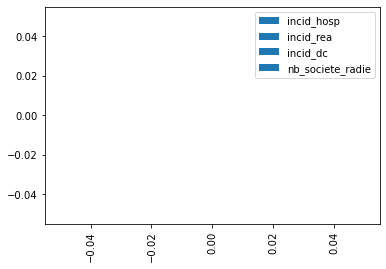

In [72]:
df_datavis = df_groupby_par_mois_societe_covid.toPandas()
df_datavis.plot(kind='bar', x='month', y=["incid_hosp", "incid_rea", "incid_dc", "nb_societe_radie"])
plt.show()

## Conclusion

Pour conclure, nous pouvons constaté avec ce graphique  que le covid a eu un impacte sur les dsociete enf rance en 2020.

Nous voyons ici que l'impacte est effectif 2 mois apres les piques

Par exemple en mars/ avril il y a une augmentation d'hospitalisation ce qui est répercuter 2 mois apres avec l'augmentation du nombre de societe radié.

**OUI** le covid a eu un impacte sur les societe en france